In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

FILE = '../data/carotene/data_random_pool.mat'
ENZYMES = ['E', 'I', 'YB']
TARGET = ['prod']

def data_to_df(file: str) -> pd.DataFrame:
    """ Load data from .mat file and convert to pandas DataFrame"""
    data = loadmat(file)
    df = pd.DataFrame(data['TrainingSet'], columns=ENZYMES + TARGET)
    df[ENZYMES] = df[ENZYMES].round(4)
    return df

def get_enzyme_levels(df: pd.DataFrame) -> list:
    """ Get all unique values in the columns in the list """
    unique_values = []
    for col in ENZYMES:
        unique_values += df[col].unique().tolist()
    return np.unique(unique_values)

def create_comb_space(df: pd.DataFrame) -> pd.DataFrame:
    """ Create a combination space for all unique values in the columns in the list """
    enzyme_levels = get_enzyme_levels(df)
    comb_space = pd.DataFrame(np.array(np.meshgrid(*[enzyme_levels]*3)).T.reshape(-1, 3), columns=ENZYMES)
    return comb_space

def linlog_transformation(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """ Perform linlog transformation on the columns in the list """
    log_data = np.log10(df[columns])
    scaled_data = 2 * (log_data - log_data.min()) / (log_data.max() - log_data.min()) - 1
    return scaled_data



In [2]:
df = data_to_df(FILE)
comb_space = create_comb_space(df)

ENZYME_LEVELS = get_enzyme_levels(df)
print(f'Number of unique enzyme levels: {len(ENZYME_LEVELS)}')

df_scaled = linlog_transformation(df, ENZYMES).round(2)
comb_space_scaled = linlog_transformation(comb_space, ENZYMES).round(2)

# From comb_space_scaled remove rows that are in df_scaled
comb_space_scaled = comb_space_scaled[~comb_space_scaled.isin(df_scaled)].dropna()

Number of unique enzyme levels: 10


In [3]:
# Get X_train, y_train and X_test
X_train = df_scaled[ENZYMES].values
y_train = df[TARGET].values.ravel()

# Normalize the target
y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min()) 

X_test = comb_space_scaled[ENZYMES].values

Machine Learning Modeling

In [8]:
import tensorflow as tf  
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Create the ANN model
nn = Sequential()
nn.add(Dense(2, input_dim=X_train.shape[1], activation=tf.math.log_sigmoid))
nn.add(Dense(1, activation='linear'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
nn.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model
history = nn.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=1)


Epoch 1/100


1/1 [==============================] - 0s 469ms/step - loss: 0.1489 - val_loss: 0.0474
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1353 - val_loss: 0.0377
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1229 - val_loss: 0.0292
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1116 - val_loss: 0.0220
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1014 - val_loss: 0.0160
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0925 - val_loss: 0.0113
Epoch 7/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0846 - val_loss: 0.0077
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0778 - val_loss: 0.0052
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0721 - val_loss: 0.0037
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0673 - val_loss: 0.0030
Epoch 11/100
1/1 [============

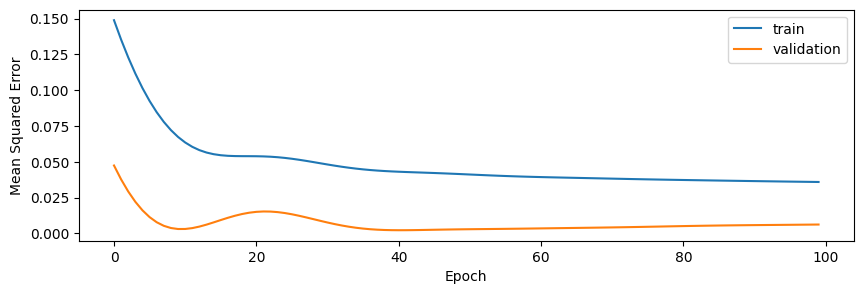

In [9]:
# Plot the training history
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [10]:
y_pred = nn.predict(X_train)

results = pd.DataFrame({'y_true': y_train, 'y_pred': y_pred.ravel()})

1/1 [==============================] - 0s 42ms/step


In [11]:
# import the necessary packages
from omlt import OmltBlock, OffsetScaling
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import FullSpaceSmoothNNFormulation
import pyomo.environ as pyo

nn.save('reformer_nn.keras')

# first, create the Pyomo model
m = pyo.ConcreteModel()
m.reformer = OmltBlock()

nn_reformer = keras.models.load_model('reformer_nn.keras', compile=False)
net = load_keras_sequential(nn_reformer)

# create the variables and constraints for the neural network in Pyomo
m.reformer.build_formulation(FullSpaceSmoothNNFormulation(net))



In [28]:
solver = pyo.SolverFactory('gurobi')
status = solver.solve(m, tee=True)

ValueError: Model constraint (reformer.layer[140268871508912]._smooth_monotonic_activation_constraint[0]) contains nonlinear terms that cannot be written to LP format

In [ ]:
comb_space_scaled['prod'] = model.predict(X_test)
comb_space_scaled.sort_values('prod', ascending=False).head(20)

32/32 [==============================] - 0s 2ms/step


,E,I,YB,prod
999,1.00,1.00,1.00,0.708829
989,0.89,1.00,1.00,0.685069
998,1.00,0.89,1.00,0.678175
899,1.00,1.00,0.89,0.671731
988,0.89,0.89,1.00,0.654901
889,0.89,1.00,0.89,0.648378
898,1.00,0.89,0.89,0.641680
979,0.68,1.00,1.00,0.640544
997,1.00,0.68,1.00,0.622128
888,0.89,0.89,0.89,0.618827
